Kirkpatrick Initialization & Huang Cooling.

In [3]:
import numpy as np
import math

rng1 = np.random.default_rng(seed=0)

def objective_function(x):
    """Keane's Bump function.
    n = dimension of the domain
    x = vector in the domain"""
    cos4 = 0
    cos2 = 1
    x_i = 0
    n = len(x)
    for i in range(n):
        cos4 += math.cos(x[i])**4
        cos2 *= math.cos(x[i])**2
        x_i += (i+1)*(x[i]**2)
    if x_i == 0:
        answer = None
    else:
        answer = np.abs((cos4 - 2*cos2)/math.sqrt(x_i))
    ## we are turning the maximization problem into a minimization problem
    return -1 * answer

def update_D(D, R):
    D =  0.9 * D + 0.21 * R
    min_step_size = 1e-3
    max_step_size = 1
    D = np.where(D < min_step_size, min_step_size, D)
    D = np.where(D > max_step_size, max_step_size, D)
    return D

def decrement_temperature(T, alpha):
    return T*alpha

def decrement_temperature_huang(T, accepted_solutions_at_T):
    alpha = max(0.5, np.exp(- 0.7 * T / np.std(accepted_solutions_at_T)))
    return T*alpha

def proposal(x, D, rng): ## Parks 1991
    while True:
        u = rng.uniform(-1, 1, size=len(x))
        x_new = x + np.dot(D, u)
        if np.all((x_new > 0) & (x_new < 10)):
            if np.sum(x_new) < 15 * len(x) / 2 and np.prod(x_new) > 0.75:
                break
    return x_new, u

def archive_function(x, archive, unchanged_counter, convergence_curve):
    ## 10 best solutions 
    archive_limit = 10
    f = objective_function(x)
    if len(archive) < archive_limit:
        archive.append((x, f))
    else:
        archive.append((x, f))  # Update all elements
        archive.sort(key=lambda item: item[1])  # Sort the archive by objective function value
        archive = archive[:archive_limit]  # Keep only the top elements
    if np.array_equal(archive[0][0],x): ## if current solution is the best solution in archive, reset counter
        unchanged_counter = 0
    else:
        unchanged_counter += 1
    convergence_curve.append(archive[0])
    return archive, unchanged_counter, convergence_curve

def find_Tin_White(Lk, n, rng): ## White 1984
    Tin = []
    for i in range(25):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        acceptanced_objectives = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            acceptanced_objectives.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(np.std(acceptanced_objectives))
    return np.average(Tin)

def find_Tin_kirkpatrick(Lk, n, rng): ## Kirkpatrick 1984
    Tin = []
    for i in range(50):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        accepted_deltas = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            if delta > 0:
                accepted_deltas.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(-1 * np.sum(accepted_deltas) / math.log(0.8))
    return np.average(Tin)

def main(x0, Lk, rng):
    x_prev = x0
    # T = find_Tin_White(Lk, len(x0), rng)
    T = find_Tin_kirkpatrick(Lk, len(x0), rng)
    print(f"Initial temperature: {T}")
    Din = np.identity(len(x0))
    D = Din
    accepted_solutions = []
    archive = []
    counter =  0
    max_iter = 10000
    # alpha = 0.95
    convergence_curve = []
    unchanged_counter = 0
    unchanged_threshold = 3000
    while counter < max_iter and unchanged_counter < unchanged_threshold:
        acceptances_at_T = 0
        accepted_solutions_at_T = []
        for i in range(Lk):
            x_new, u = proposal(x_prev, Din, rng)
            counter += 1
            R = np.abs(np.diag(np.dot(D, u)))
            delta = objective_function(x_new) - objective_function(x_prev)
            if delta < 0:
                x_prev = x_new
                acceptances_at_T += 1
                accepted_solutions.append(x_new)
                accepted_solutions_at_T.append(x_new)
                D = update_D(D, R)
                archive, unchanged_counter, convergence_curve = archive_function(x_new, archive, unchanged_counter, convergence_curve)
            else:
                step_size = np.sqrt(np.sum(R**2))
                p = np.exp(- (0.7 * delta) / (T * step_size))
                if p > 1:
                    print("ERROR")
                if rng.uniform() < p:
                    x_prev = x_new
                    acceptances_at_T += 1
                    accepted_solutions.append(x_new)
                    accepted_solutions_at_T.append(x_new)
                    D = update_D(D, R)
                    archive, unchanged_counter, convergence_curve = archive_function(x_new, archive, unchanged_counter, convergence_curve)
                else:
                    unchanged_counter += 1
            if acceptances_at_T / Lk >= 0.6:
                break
        # T = decrement_temperature(T, alpha)
        T = decrement_temperature_huang(T, accepted_solutions_at_T)
        print(f"New temperature: {T}, acceptances at previous T: {acceptances_at_T/ Lk}, counter: {counter}")
    return accepted_solutions, archive, convergence_curve
            


In [4]:
n = 2 ## 2D
while True:
    x = np.random.uniform(0, 10, size=n)
    if np.all((x > 0) & (x < 10)):
        if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
            break
accepted_solutions, archive, convergence_curve = main(x, 150, rng1)


Initial temperature: 9.275516103447316
New temperature: 4.637758051723658, acceptances at previous T: 0.6, counter: 90
New temperature: 2.318879025861829, acceptances at previous T: 0.6, counter: 181
New temperature: 1.2812931495976692, acceptances at previous T: 0.6, counter: 272
New temperature: 0.9483397172253502, acceptances at previous T: 0.6, counter: 364
New temperature: 0.6161411880037599, acceptances at previous T: 0.6, counter: 462
New temperature: 0.47683175016228413, acceptances at previous T: 0.6, counter: 558
New temperature: 0.41984348205744626, acceptances at previous T: 0.6, counter: 657
New temperature: 0.3752658592588793, acceptances at previous T: 0.6, counter: 751
New temperature: 0.3188005829485894, acceptances at previous T: 0.6, counter: 851
New temperature: 0.27350683326691566, acceptances at previous T: 0.6, counter: 956
New temperature: 0.25499173621864446, acceptances at previous T: 0.6, counter: 1060
New temperature: 0.23632895468056075, acceptances at prev

In [5]:
print(convergence_curve)

[(array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([6.10586372, 5.63086236]), -0.011342889255126264), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([8.13968347, 6.32665153]), -0.06977475067796444), (array([9.30731957, 

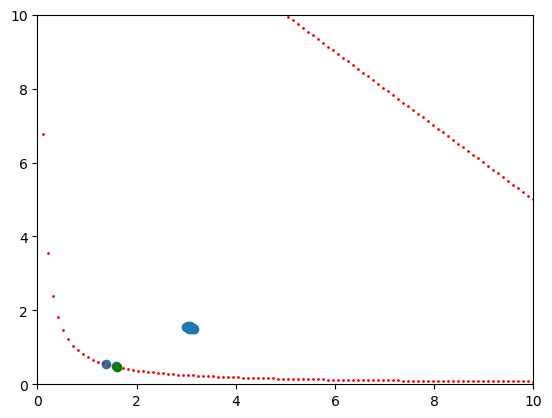

In [111]:
x1 = [t[0][0] for t in archive]
x2 = [t[0][1] for t in archive]
x = np.linspace(0.01, 10, 100)
y = 15 - x

y2 = 0.75 / x
global_minx = [1.60086044]
global_miny = [0.468498055]
import matplotlib.pyplot as plt
plt.scatter(x1, x2)
plt.scatter(x, y, c='red', s = 1)
plt.scatter(x, y2, c='red', s = 1)
plt.scatter(global_minx, global_miny, c='green')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.show()

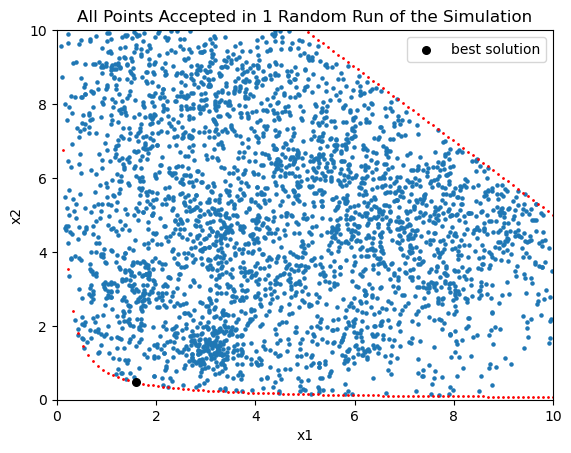

In [124]:
x1 = [t[0] for t in accepted_solutions]
x2 = [t[1] for t in accepted_solutions]
x = np.linspace(0.01, 10, 100)
y = 15 - x

y2 = 0.75 / x
global_minx = [1.60086044]
global_miny = [0.468498055]
import matplotlib.pyplot as plt
plt.scatter(x1, x2, s = 5)
plt.scatter(x, y, c='red', s = 1)
plt.scatter(x, y2, c='red', s = 1)
plt.scatter(global_minx, global_miny, c='black', s = 30, label = 'best solution')
plt.title('All Points Accepted in 1 Random Run of the Simulation')
plt.xlabel('x1')
plt.ylabel('x2')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.legend()
plt.show()

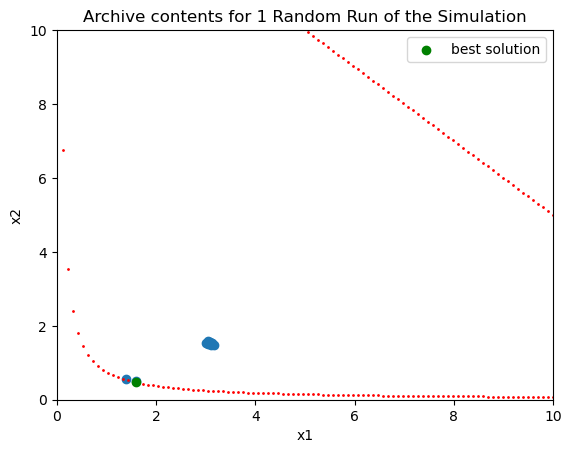

In [113]:
x1 = [t[0][0] for t in archive]
x2 = [t[0][1] for t in archive]
x = np.linspace(0.01, 10, 100)
y = 15 - x

y2 = 0.75 / x
global_minx = [1.60086044]
global_miny = [0.468498055]
import matplotlib.pyplot as plt
plt.scatter(x1, x2)
plt.scatter(x, y, c='red', s = 1)
plt.scatter(x, y2, c='red', s = 1)
plt.scatter(global_minx, global_miny, c='green', label = 'best solution')
plt.title('Archive contents for 1 Random Run of the Simulation')
plt.xlabel('x1')
plt.ylabel('x2')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.legend()
plt.show()

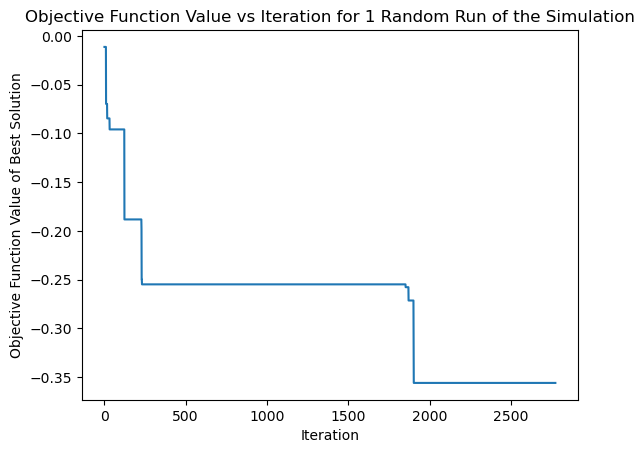

In [8]:
import matplotlib.pyplot as plt
objectivefunvalues = np.array([t[1] for t in convergence_curve])
iterations = np.arange(len(objectivefunvalues))
# iterations = iterations[::50]
# objectivefunvalues = objectivefunvalues[::50]
plt.plot(iterations, objectivefunvalues)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value of Best Solution')
plt.title('Objective Function Value vs Iteration for 1 Random Run of the Simulation')
plt.show()

In [12]:
def run_simulation():
    n = 2 ## 2D
    while True:
        x = np.random.uniform(0, 10, size=n)
        if np.all((x > 0) & (x < 10)):
            if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                break
    accepted_solutions, archive, convergence_curve = main(x, 100, rng1)
    return archive[0][0], archive[0][1]
best = []
for i in range(25):
    x, f = run_simulation()
    best.append((x, f))
print(best)


Initial temperature: 6.394464517717456
New temperature: 3.197232258858728, acceptances at previous T: 0.6, counter: 60
New temperature: 1.598616129429364, acceptances at previous T: 0.6, counter: 120
New temperature: 0.9277366988184711, acceptances at previous T: 0.6, counter: 182
New temperature: 0.7500389460154313, acceptances at previous T: 0.6, counter: 244
New temperature: 0.6228511668719353, acceptances at previous T: 0.6, counter: 305
New temperature: 0.5253276580447791, acceptances at previous T: 0.6, counter: 366
New temperature: 0.470663648807275, acceptances at previous T: 0.6, counter: 429
New temperature: 0.4228399381118416, acceptances at previous T: 0.6, counter: 491
New temperature: 0.37749683891927654, acceptances at previous T: 0.6, counter: 553
New temperature: 0.336823385081569, acceptances at previous T: 0.6, counter: 617
New temperature: 0.3129543751610929, acceptances at previous T: 0.6, counter: 682
New temperature: 0.29304675397132013, acceptances at previous T

c:\Users\sharm\anaconda3\envs\pracop2\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sharm\anaconda3\envs\pracop2\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\sharm\anaconda3\envs\pracop2\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New temperature: 0.016156277856609728, acceptances at previous T: 0.01, counter: 2933
New temperature: 0.008078138928304864, acceptances at previous T: 0.0, counter: 3033
New temperature: 0.004039069464152432, acceptances at previous T: 0.0, counter: 3133
New temperature: 0.004024467776545772, acceptances at previous T: 0.01, counter: 3233
New temperature: 0.002012233888272886, acceptances at previous T: 0.0, counter: 3333
New temperature: 0.001006116944136443, acceptances at previous T: 0.0, counter: 3433
New temperature: 0.0005030584720682214, acceptances at previous T: 0.0, counter: 3533
New temperature: 0.0002515292360341107, acceptances at previous T: 0.0, counter: 3633
New temperature: 0.00012576461801705536, acceptances at previous T: 0.0, counter: 3733
New temperature: 6.288230900852768e-05, acceptances at previous T: 0.0, counter: 3833
New temperature: 3.144115450426384e-05, acceptances at previous T: 0.0, counter: 3933
New temperature: 1.572057725213192e-05, acceptances at pr

In [15]:
print(np.min([t[1] for t in best]))

## 1.607, 0.468

-0.36481356664711617


White Temperature initialization.

In [1]:
import numpy as np
import math

rng1 = np.random.default_rng(seed=0)

def objective_function(x):
    """Keane's Bump function.
    n = dimension of the domain
    x = vector in the domain"""
    cos4 = 0
    cos2 = 1
    x_i = 0
    n = len(x)
    for i in range(n):
        cos4 += math.cos(x[i])**4
        cos2 *= math.cos(x[i])**2
        x_i += (i+1)*(x[i]**2)
    if x_i == 0:
        answer = None
    else:
        answer = np.abs((cos4 - 2*cos2)/math.sqrt(x_i))
    ## we are turning the maximization problem into a minimization problem
    return -1 * answer

def update_D(D, R):
    D =  0.9 * D + 0.21 * R
    min_step_size = 1e-3
    max_step_size = 1
    D = np.where(D < min_step_size, min_step_size, D)
    D = np.where(D > max_step_size, max_step_size, D)
    return D

def decrement_temperature(T, alpha):
    return T*alpha

def decrement_temperature_huang(T, accepted_solutions_at_T):
    alpha = max(0.5, np.exp(- 0.7 * T / np.std(accepted_solutions_at_T)))
    return T*alpha

def proposal(x, D, rng): ## Parks 1991
    while True:
        u = rng.uniform(-1, 1, size=len(x))
        x_new = x + np.dot(D, u)
        if np.all((x_new > 0) & (x_new < 10)):
            if np.sum(x_new) < 15 * len(x) / 2 and np.prod(x_new) > 0.75:
                break
    return x_new, u

def archive_function(x, archive, unchanged_counter):
    ## 10 best solutions 
    archive_limit = 10
    f = objective_function(x)
    if len(archive) < archive_limit:
        archive.append((x, f))
    else:
        archive.append((x, f))  # Update all elements
        archive.sort(key=lambda item: item[1])  # Sort the archive by objective function value
        archive = archive[:archive_limit]  # Keep only the top elements
    if np.array_equal(archive[0][0],x): ## if current solution is the best solution in archive, reset counter
        unchanged_counter = 0
    else:
        unchanged_counter += 1
    return archive, unchanged_counter

def find_Tin_White(Lk, n, rng): ## White 1984
    Tin = []
    for i in range(25):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        acceptanced_objectives = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            acceptanced_objectives.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(np.std(acceptanced_objectives))
    return np.average(Tin)

def find_Tin_kirkpatrick(Lk, n, rng): ## Kirkpatrick 1984
    Tin = []
    for i in range(50):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        accepted_deltas = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            if delta > 0:
                accepted_deltas.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(-1 * np.sum(accepted_deltas) / math.log(0.8))
    return np.average(Tin)

def main(x0, Lk, rng):
    x_prev = x0
    # T = find_Tin_White(Lk, len(x0), rng)
    T = find_Tin_kirkpatrick(Lk, len(x0), rng)
    print(f"Initial temperature: {T}")
    Din = np.identity(len(x0))
    D = Din
    accepted_solutions = []
    archive = []
    counter =  0
    max_iter = 10000
    alpha = 0.95
    unchanged_counter = 0
    unchanged_threshold = 3000
    while counter < max_iter and unchanged_counter < unchanged_threshold:
        acceptances_at_T = 0
        accepted_solutions_at_T = []
        for i in range(Lk):
            x_new, u = proposal(x_prev, Din, rng)
            counter += 1
            R = np.abs(np.diag(np.dot(D, u)))
            delta = objective_function(x_new) - objective_function(x_prev)
            if delta < 0:
                x_prev = x_new
                acceptances_at_T += 1
                accepted_solutions.append(x_new)
                accepted_solutions_at_T.append(x_new)
                D = update_D(D, R)
                archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
            else:
                step_size = np.sqrt(np.sum(R**2))
                p = np.exp(- (0.7 * delta) / (T * step_size))
                if p > 1:
                    print("ERROR")
                if rng.uniform() < p:
                    x_prev = x_new
                    acceptances_at_T += 1
                    accepted_solutions.append(x_new)
                    accepted_solutions_at_T.append(x_new)
                    D = update_D(D, R)
                    archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
                else:
                    unchanged_counter += 1
            if acceptances_at_T / Lk >= 0.6:
                break
        # T = decrement_temperature(T, alpha)
        T = decrement_temperature_huang(T, accepted_solutions_at_T)
        print(f"New temperature: {T}, acceptances at previous T: {acceptances_at_T/ Lk}, counter: {counter}")
    return accepted_solutions, archive
            
n = 2 ## 2D
while True:
    x = np.random.uniform(0, 10, size=n)
    if np.all((x > 0) & (x < 10)):
        if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
            break
accepted_solutions, archive = main(x, 150, rng1)


Initial temperature: 11.0978172889683
New temperature: 5.54890864448415, acceptances at previous T: 0.6, counter: 90
New temperature: 2.774454322242075, acceptances at previous T: 0.6, counter: 180
New temperature: 1.3872271611210376, acceptances at previous T: 0.6, counter: 272
New temperature: 0.8750794014237088, acceptances at previous T: 0.6, counter: 363
New temperature: 0.6569167769064908, acceptances at previous T: 0.6, counter: 456
New temperature: 0.4712699991905713, acceptances at previous T: 0.6, counter: 550
New temperature: 0.41725787265070924, acceptances at previous T: 0.6, counter: 651
New temperature: 0.37492282383382053, acceptances at previous T: 0.6, counter: 745
New temperature: 0.31516188290340985, acceptances at previous T: 0.6, counter: 855
New temperature: 0.2841028493676554, acceptances at previous T: 0.6, counter: 950
New temperature: 0.26175693798425115, acceptances at previous T: 0.6, counter: 1061
New temperature: 0.2408644690901742, acceptances at previou

In [2]:
print(archive)

[(array([1.55196096, 0.49543848]), -0.35147761235723046), (array([1.38590619, 0.56132205]), -0.29195019259447913), (array([1.42927811, 0.58871675]), -0.27281102077175107), (array([3.08748381, 1.51324825]), -0.26288676340491024), (array([3.07069241, 1.43689466]), -0.2593132678979146), (array([3.09216674, 1.61110215]), -0.25824098418003955), (array([3.11691913, 1.41788365]), -0.2571222420737753), (array([3.20181236, 1.5555493 ]), -0.2554380294096471), (array([3.0388703 , 1.39470628]), -0.2537470348528473), (array([2.95571353, 1.49365861]), -0.2536292792833672)]


Both work equally well!